In [11]:
from fastai.tabular.all import *

# Load the csv
df = pd.read_csv('./Theft_from_Motor_Vehicle.csv')
df.head()

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.835512e+06,5.418252e+06,1,GO-20141260616,D53,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mobile)",House,2142,...,1.0,1.0,Wednesday,2,NonMCI,56,Leaside-Bennington,-79.370758,43.694274,1
1,-8.844479e+06,5.422776e+06,2,GO-20149000010,D32,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,...,31.0,365.0,Tuesday,15,NonMCI,31,Yorkdale-Glen Park,-79.451310,43.723650,2
2,-8.836012e+06,5.410878e+06,3,GO-20141261694,D51,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,"Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)",Commercial,2142,...,1.0,1.0,Wednesday,1,NonMCI,77,Waterfront Communities-The Island,-79.375245,43.646361,3
3,-8.849244e+06,5.422821e+06,4,GO-20141262668,D31,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,...,31.0,365.0,Tuesday,18,NonMCI,26,Downsview-Roding-CFB,-79.494115,43.723947,4
4,-8.838679e+06,5.410277e+06,5,GO-20141261604,D14,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,...,31.0,365.0,Tuesday,16,NonMCI,77,Waterfront Communities-The Island,-79.399201,43.642458,5


In [12]:
# Only keep occurrencedate and Hood_ID
df = df[['occurrencedate', 'Hood_ID', 'location_type']]
df.head()


,occurrencedate,Hood_ID,location_type
0,2014/01/01 05:00:00+00,56,"Single Home, House (Attach Garage, Cottage, Mobile)"
1,2013/12/31 05:00:00+00,31,"Parking Lots (Apt., Commercial Or Non-Commercial)"
2,2014/01/01 05:00:00+00,77,"Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)"
3,2013/12/31 05:00:00+00,26,"Parking Lots (Apt., Commercial Or Non-Commercial)"
4,2013/12/31 05:00:00+00,77,"Parking Lots (Apt., Commercial Or Non-Commercial)"


In [13]:
# Convert ocurrencedate to only date
df['occurrencedate'] = df['occurrencedate'].apply(lambda x: x.split(' ')[0])
df.head()

,occurrencedate,Hood_ID,location_type
0,2014/01/01,56,"Single Home, House (Attach Garage, Cottage, Mobile)"
1,2013/12/31,31,"Parking Lots (Apt., Commercial Or Non-Commercial)"
2,2014/01/01,77,"Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)"
3,2013/12/31,26,"Parking Lots (Apt., Commercial Or Non-Commercial)"
4,2013/12/31,77,"Parking Lots (Apt., Commercial Or Non-Commercial)"


In [14]:
# Convert ocurrencedate to datetime
df['occurrencedate'] = pd.to_datetime(df['occurrencedate'], format='%Y/%m/%d')

# Filter out occurrencedate before 2015
df = df[df['occurrencedate'] > '2015-01-01']

# Sort by occurrencedate
df = df.sort_values(by='occurrencedate')

# Group by occurrencedate datetime and features
df = df.groupby([df['occurrencedate'].dt.date, 'Hood_ID',
                'location_type']).size().reset_index(name='thefts')

df.head()


,occurrencedate,Hood_ID,location_type,thefts
0,2015-01-02,1,"Parking Lots (Apt., Commercial Or Non-Commercial)",1
1,2015-01-02,1,"Single Home, House (Attach Garage, Cottage, Mobile)",1
2,2015-01-02,1,"Streets, Roads, Highways (Bicycle Path, Private Road)",1
3,2015-01-02,108,"Parking Lots (Apt., Commercial Or Non-Commercial)",1
4,2015-01-02,109,"Parking Lots (Apt., Commercial Or Non-Commercial)",1


In [15]:
# Save df to csv
df.to_csv('./date_hood_loctype_thefts.csv', index=False)

# Save df withouth location_type
df_clean = df[['occurrencedate', 'Hood_ID', 'thefts']]
df_clean.to_csv('./date_hood_thefts.csv', index=False)


In [16]:
splits = EndSplitter(valid_pct=0.4, valid_last=True)
dls = TabularDataLoaders.from_df(df, procs=[Categorify, FillMissing, Normalize],
              cat_names=['Hood_ID', 'location_type', 'occurrencedate', 'thefts'],
              y_names=['thefts'], splits=splits)
learn = tabular_learner(dls, metrics=rmse)

/home/vscode/.local/lib/python3.10/site-packages/fastai/tabular/core.py:279: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  to.conts = (to.conts-self.means) / self.stds


In [17]:
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,_rmse,time
0,0.022319,0.008190,0.090499,00:06
1,0.016511,0.005341,0.073084,00:06
2,0.008899,0.003863,0.062154,00:06
3,0.004653,0.003074,0.055443,00:06
4,0.003752,0.002739,0.052336,00:06


In [18]:
# Get the predictions and target values
preds, targs = learn.get_preds()
print(preds)
print(targs)

tensor([[1.0099],
        [1.0089],
        [1.0067],
        ...,
        [2.0391],
        [1.9750],
        [1.0028]])
tensor([[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [1]], dtype=torch.int8)


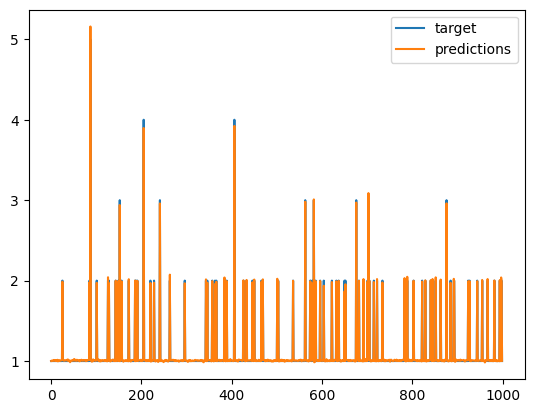

In [19]:
# Plot predictions vs target in a line plot las 4000 values
plt.plot(targs[-1000:], label='target')
plt.plot(preds[-1000:], label='predictions')
plt.legend()
plt.show()

In [20]:
# With sckiit-learn calculate the mean squared error and accuracy
from sklearn.metrics import mean_squared_error, accuracy_score

# Round the predictions to the nearest integer
preds = np.round(preds)

print('Mean squared error: ', mean_squared_error(targs, preds))
print('Accuracy: ', accuracy_score(targs, preds))


Mean squared error:  0.0024797488
Accuracy:  0.9997520251281203
